# Text generation with character based RNNs

Create and train LSTM neural network that generates new text based on the short input text. Network shoudl generate the text in the same style as training text


# 1. Download, read and prepare text data

In [5]:
# !wget https://wolnelektury.pl/media/book/txt/pan-tadeusz.txt
!wget https://pgentil.github.io/pages/asv.txt

--2024-02-13 06:56:49--  https://pgentil.github.io/pages/asv.txt
Resolving pgentil.github.io (pgentil.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to pgentil.github.io (pgentil.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4576325 (4.4M) [text/plain]
Saving to: ‘asv.txt’

asv.txt             100%[===================>]   4.36M  --.-KB/s    in 0.09s   

2024-02-13 06:56:49 (47.7 MB/s) - ‘asv.txt’ saved [4576325/4576325]



In [6]:

import random
import re
import torch
import torch.nn as nn


#reading
# with open('pan-tadeusz.txt', 'r') as f:
with open('asv.txt', 'r') as f:
    file=f.read()
file_len = len(file)

print('Text length: ', file_len)



Text length:  4576325


## Create a set of all charaters  and save number of charaters for later use

In [13]:
all_characters =''.join(set(file))
n_characters = len(all_characters)
print(all_characters)
print(n_characters)

h;oWly8!pB1P
6x7YqHA:0.[9MJnuz<j)USdEewIG(N35RsvVZtaifm}b'KT{=]rCk2DOcF/ Qg,?4L->"
82


## Write function that returns the random text chunk of a given length "chunk_len"

In [11]:
chunk_len = 200

def random_chunk():

    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

rand=random_chunk()

print(rand)


city of David, at the ascent of the wall, above the house of David, even unto the water gate eastward.
Nehemiah 12:38 And the other company of them that gave thanks went to meet them, and I after them,


## Write function that returns the indices of characters from a given string in "all_characters"

In [14]:

def char_to_idx(string):
    tensor = torch.zeros(len(string)).long()#type long, we don't want float
    for c in range(len(string)): #c is index of current character in string
          tensor[c] = all_characters.index(string[c]) # find index of current character in all_characters
    return tensor

print(char_to_idx('abc'))




tensor([51, 56, 69])


In [15]:
char_to_idx(rand)

tensor([69, 52, 50,  5, 72,  2, 53, 72, 67, 51, 47, 52, 35, 75, 72, 51, 50, 72,
        50,  0, 37, 72, 51, 46, 69, 37, 27, 50, 72,  2, 53, 72, 50,  0, 37, 72,
        38, 51,  4,  4, 75, 72, 51, 56,  2, 47, 37, 72, 50,  0, 37, 72,  0,  2,
        28, 46, 37, 72,  2, 53, 72, 67, 51, 47, 52, 35, 75, 72, 37, 47, 37, 27,
        72, 28, 27, 50,  2, 72, 50,  0, 37, 72, 38, 51, 50, 37, 63, 72, 74, 51,
        50, 37, 72, 37, 51, 46, 50, 38, 51, 63, 35, 22, 12, 42, 37,  0, 37, 54,
        52, 51,  0, 72, 10, 66, 20, 43,  6, 72, 19, 27, 35, 72, 50,  0, 37, 72,
         2, 50,  0, 37, 63, 72, 69,  2, 54,  8, 51, 27,  5, 72,  2, 53, 72, 50,
         0, 37, 54, 72, 50,  0, 51, 50, 72, 74, 51, 47, 37, 72, 50,  0, 51, 27,
        65, 46, 72, 38, 37, 27, 50, 72, 50,  2, 72, 54, 37, 37, 50, 72, 50,  0,
        37, 54, 75, 72, 51, 27, 35, 72, 39, 72, 51, 53, 50, 37, 63, 72, 50,  0,
        37, 54, 75])

## Create function that returns training sample using a random chuck of text. The input is all characters of chunk without the last one, the target is all characters without the first one

In [16]:
def random_training_set():
    chunk = random_chunk()
    inp = char_to_idx(chunk[:-1])
    target = char_to_idx(chunk[1:])
    return inp, target

# 2. Create class for  model of neural network
 Every model class in pyTorch inherits from nn.Module.

 The model usually consist of two methods: __init__ and __forward__. In our model we need also __init_hidden__

 - __init__ - declared within a class, is used to initialize the attributes of an object as soon as the object is formed. In our case we initialize
     - attributes :  input_size, embed_size, hidden_size, output_size, n_layers
     - layers/modules:
         - nn.Embedding - A simple lookup table that stores embeddings. Embeddings are retrieved using indices. The input to the module is a list of indices, and the output is the corresponding word embeddings. Parameters: input size, embed_size https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html#torch.nn.Embedding
         - nn.LSTM - Apply a multi-layer long short-term memory (LSTM) RNN to an input sequence. Parameters: embed_size, hidden_size, n_layers https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#lstm
         - nn.Linear - Dense Layer. Parameters hidden_size, output_size https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#linear
      
- __forward__ - calculates all the operations inside neural net. Arguments for RNN input, hidden state from previous step.
    - first convert input indices to embeddings
    - pass embedding and hidden state(together with cell state (h_t-1, c_t-1)) to LSTM that returns the output and hidden state together with cell state (h_t, c_t)
    - -pass the output throu linear layer
    - return output of linear layer and hidden state ((h_t, c_t))

- __init_hidden__ - return the initial value of hidden and cell state h_0, c_0 - in our case zero vectors


In [17]:


class RNN(nn.Module):
    def __init__(self, input_size, embed_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        #Your code
        self.input_size = input_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        #######YOUR CODE########
        self.embed = nn.Embedding(input_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, n_layers)
        self.linear = nn.Linear(hidden_size, output_size)
        #########################

    def forward(self, inp, hidden):

        inp=inp.view(1, -1) #as our input is a single index we have to convert it to tensor with proper shape

        #######YOUR CODE########
        e = self.embed(inp) # <-get EMBEDDING for input

        output, hidden =  self.lstm(e, hidden)  # <-get LSTM outputs
        #############################

        output = self.linear(output.squeeze(0))# reduce the dimension of the lstm output and pass through linear layer
        return output, hidden

    def init_hidden(self):
        return (torch.zeros(self.n_layers, 1, self.hidden_size),
                torch.zeros(self.n_layers, 1, self.hidden_size))

## Create model instance, optimizer and loss function

In [18]:
embed_size=100
hidden_size = 100
n_layers = 1
lr = 0.005
##


########### YOUR CODE#######
rnn = RNN(n_characters, embed_size, hidden_size, n_characters, n_layers) #your code - input_size and  output_size is the same -number of characters
############################
rnn_optimizer = torch.optim.SGD(rnn.parameters(), lr=lr, momentum=0.6)
criterion = nn.CrossEntropyLoss()

## Write function that return a sample of generated texts. This function is used during training to control the generated output

In [19]:
import random


def sample(start_str='A', predict_len=100):
    #initialize the hidden state of network
    hidden = rnn.init_hidden()
    start_input = char_to_idx(start_str) #change input to indices
    predicted = start_str# set beggining of predicted sequence

    #run network on every character from start_str to learn the input sequence
    for p in range(len(start_str) - 1):
        _, hidden = rnn(start_input[p], hidden) #your code

    #last character is now the input
    inp = start_input[-1]

    #generate new characters
    for p in range(predict_len):

        ########## YOUR CODE ############
        output, hidden = rnn(inp, hidden) #your code - run network with the current input and
        #################################

        top_v, top_i = output.data.view(-1).topk(3)# choose top k characters with best score
        top_i = random.choice(top_i)#top_i[0]



        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_to_idx(predicted_char) #set inp as new predicted char (you could just do inp = top_i)



    return predicted

In [20]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

# 3. Train the network

In [21]:
def train(inp, target):
    hidden = rnn.init_hidden() #initialize the hidden state of network before every training sample
    rnn_optimizer.zero_grad() # set gradient network as zero to not cumulate gradients from previous steps
    loss = 0
    for c in range(0,chunk_len-1):

        output, hidden = rnn(inp[c], hidden) #make prediction
        loss += criterion(output, target[c].view(1)) # calculate loss

    loss.backward() # calculate gradient
    rnn_optimizer.step()# update parameters of network

    return loss.data/ chunk_len

In [ ]:
#paramters
n_epochs = 6000
print_every = 100
plot_every = 10


start = time.time()
all_losses = []
loss_avg = 0

#train and check result every "print_every" step and save loss every "plot_every" step
for epoch in range(1, n_epochs + 1):
    x,target = random_training_set()
    loss = train(x, target)
    loss_avg += loss

    if epoch % print_every == 0:
        print('%s (%d %d%%) %.4f' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(sample('Gdy', 200), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

## plot the resulting loss

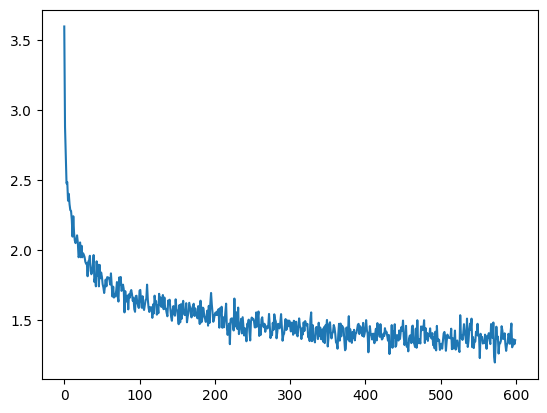

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

helpful tutorials for rnns in pyTorch:

https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html
https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html

tutorials code inspired by https://github.com/rasbt/stat453-deep-learning-ss21/blob/main/L19/character-rnn/01_char-rnn_lstm-ver.ipynb.ipynb